In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import levene
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, mannwhitneyu
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

In [25]:
df_2023= pd.read_csv('data/2023/외래관광객조사_2023_전처리3(세분화).csv')
df_2024= pd.read_csv('data/2024/외래관광객조사_2024_전처리3(세분화).csv')

In [26]:
# 2024년 컬럼명 통일
df_2024.rename(columns={
    '총액1인TOT_개별국제교통비제외2': '총액1인TOT항공제외2'
}, inplace=True)

In [27]:
print('총액1인TOT_개별국제교통비제외2' in df_2024.columns)

False


In [28]:
print('총액1인TOT항공제외2' in df_2024.columns)

True


In [29]:
print(df_2024.columns.tolist())

['D_NAT', 'M일HAP', 'Q7A', 'Q7a_dk', 'Q7a2', 'Q7a3', 'Q7a4', 'Q7a5', 'Q7a6', 'Q7a7', 'Q7a8', 'D_GUB', 'D_MOK', '총액1인TOT항공제외2', 'Q8a03', 'Q8a12', 'Q8_1a1', 'Q8_1a2', 'Q8_1a3', 'D_AGE', '동행자_단순', '동행자_세분화', '국가명', '연령대_단순', '연령대_세분화', '웰니스참여', '웰니스만족', 'log_총액', 'year']


In [30]:
# 23, 24년도 데이터 병합
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

In [31]:
# 병합된 데이터 확인
print(df_all.shape)
print(df_all['year'].value_counts())  # 연도별 분포 확인

(17123, 29)
year
2024    8769
2023    8354
Name: count, dtype: int64


### 전체 연령대별 사용 총액 분석

In [32]:
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [33]:
# 연령대별 평균 총액
avg_total_by_age = df_all.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().round(1).sort_index()
print(avg_total_by_age)

연령대_단순
10대       1160.0
20대       1268.6
30~50대    1445.3
60대 이상    1252.9
Name: 총액1인TOT항공제외2, dtype: float64


- 30~50대가 총액1인소비가 가장 큰 그룹으로 나타남
- 30~50대 > 20대 > 60대 이상 > 10대 순으로 연령대별 평균 소비 총액을 확인할 수 있음 

In [34]:
df_all['연령대_세분화'].value_counts()

연령대_세분화
20대       6117
30대       4189
50대       2776
40대       2631
60대 이상     974
10대        436
Name: count, dtype: int64

In [35]:
# 연령대별 평균 총액
avg_total_by_age = df_all.groupby('연령대_세분화')['총액1인TOT항공제외2'].mean().round(1).sort_index()
print(avg_total_by_age)

연령대_세분화
10대       1160.0
20대       1268.6
30대       1465.3
40대       1476.9
50대       1385.0
60대 이상    1252.9
Name: 총액1인TOT항공제외2, dtype: float64


In [36]:
print(df_all['총액1인TOT항공제외2'].describe())

count    17123.000000
mean      1363.952237
std       1272.311095
min        139.800000
25%        665.133847
50%        987.620000
75%       1561.700000
max       9549.510000
Name: 총액1인TOT항공제외2, dtype: float64


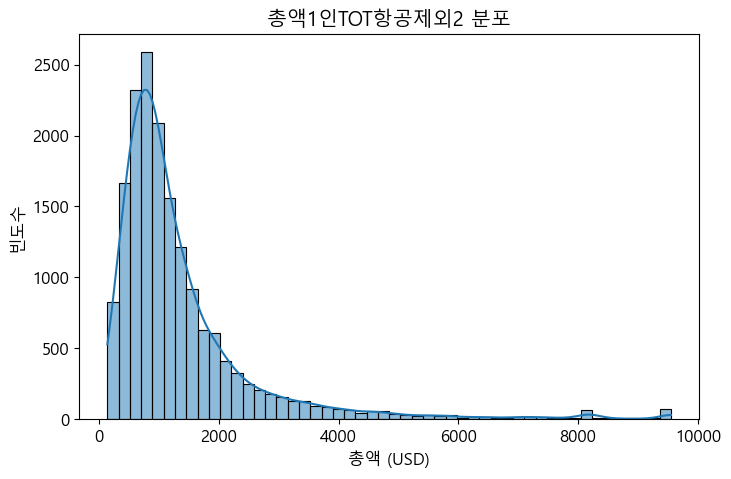

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(df_all['총액1인TOT항공제외2'], bins=50, kde=True)
plt.title("총액1인TOT항공제외2 분포")
plt.xlabel("총액 (USD)")
plt.ylabel("빈도수")
plt.show()

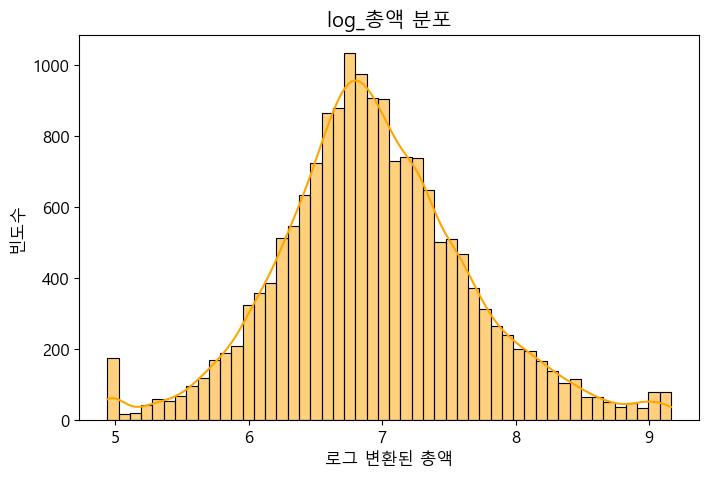

In [38]:
plt.figure(figsize=(8, 5))
sns.histplot(df_all['log_총액'], bins=50, kde=True, color='orange')
plt.title("log_총액 분포")
plt.xlabel("로그 변환된 총액")
plt.ylabel("빈도수")
plt.show()

In [39]:
# 연령대별 평균 log_총액 구하기
avg_log_by_age = df_all.groupby('연령대_단순')['log_총액'].mean().round(3)
print(avg_log_by_age)

연령대_단순
10대       6.798
20대       6.870
30~50대    7.003
60대 이상    6.829
Name: log_총액, dtype: float64


In [40]:
df_all['예상_총액'] = np.exp(df_all['log_총액']) - 1

In [41]:
avg_total_by_age = df_all.groupby('연령대_단순')['예상_총액'].mean().round(1)
print(avg_total_by_age)

연령대_단순
10대       1159.0
20대       1267.6
30~50대    1444.3
60대 이상    1251.9
Name: 예상_총액, dtype: float64


### 연령대별 자녀 동반 여부에 따른 소비 총액 차이

#### 연령대_단순 기준 
- 10대, 20대, 30~50대, 60대 이상

In [42]:
# 동행자_세분화 컬럼 중에서 '자녀'와 함께온 관광객은 자녀O, 아닌 그룹은 자녀X 그룹으로 나눔
df_all['자녀동반'] = df_all['동행자_세분화'].apply(lambda x: '자녀O' if x == '자녀' else '자녀X')

In [43]:
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [44]:
df_all.query("자녀동반 == '자녀O'").groupby('연령대_단순').size()

연령대_단순
10대         1
20대        15
30~50대    698
60대 이상    114
dtype: int64

In [45]:
df_all.query("자녀동반 == '자녀O'").groupby('연령대_세분화').size()

연령대_세분화
10대         1
20대        15
30대       113
40대       206
50대       379
60대 이상    114
dtype: int64

In [46]:
print(df_all['자녀동반'].unique())

['자녀X' '자녀O']


In [47]:
# 10대 제외 필터링
df_filtered = df_all[df_all['연령대_단순'] != '10대']

In [48]:
# 연령대별 × 자녀 동반 여부별 평균 소비액 확인
## 예상 총액 기준으로 평균 비교
pivot = df_filtered.pivot_table(
    index='연령대_단순',
    columns='자녀동반',
    values='총액1인TOT항공제외2',
    aggfunc='mean'
).round(1)

print(pivot)

자녀동반       자녀O     자녀X
연령대_단순                
20대     1361.4  1268.4
30~50대  1299.2  1456.7
60대 이상  1173.4  1263.5


In [49]:
# 자녀 동반 비율
# 전체 인원 수
total = df_filtered.groupby('연령대_단순').size()

# 자녀동반 인원 수
with_child = df_filtered[df_filtered['자녀동반'] == '자녀O'].groupby('연령대_단순').size()

# 비율 계산
pivot['자녀동반비율'] = (with_child / total * 100).round(1).astype(str) + '%'

print(with_child)
pivot['자녀동반비율']

연령대_단순
20대        15
30~50대    698
60대 이상    114
dtype: int64


연령대_단순
20대        0.2%
30~50대     7.3%
60대 이상    11.7%
Name: 자녀동반비율, dtype: object

| 연령대     | 자녀O 평균 소비액 | 자녀X 평균 소비액 | 차이 (자녀X - 자녀O)            |
| ------- | ---------- | ---------- | ------------------------- |
| 20대     | \$1,361.4  | \$1,268.4  | **-93.0** (자녀 동반 시 소비 ↑)  |
| 30\~50대 | \$1,299.2  | \$1,456.7  | **+157.5** (자녀 동반 시 소비 ↓) |
| 60대 이상  | \$1,173.4  | \$1,263.5  | **+90.1** (자녀 동반 시 소비 ↓)  |


- 20대만 자녀 동반 시 소비가 증가 (다만, 표본수가 다른 그룹보다 적음)
- 30~50대는 자녀 동반 시 평균 소비 감소 
- 자녀 미동반 시 평균 소비가 약 $157 더 높음
- 자녀 동반 시 비용 부담을 줄이거나, 여행 스타일 자체가 달라질 가능성 존재
- 60대도 비슷한 경향 (자녀 미동반 시 소비가 더 높음)

- 30~50대: 자녀 없이 여행하는 중장년층이 가장 높은 소비력 보유층으로 타겟팅 가치 큼

#### 연령대_세분화 기준

In [50]:
df_all.query("자녀동반 == '자녀O'").groupby('연령대_세분화').size()

연령대_세분화
10대         1
20대        15
30대       113
40대       206
50대       379
60대 이상    114
dtype: int64

In [51]:
# 10대 제외 필터링
df_filtered = df_all[df_all['연령대_세분화'] != '10대']

In [52]:
# 연령대별 × 자녀 동반 여부별 평균 소비액 확인
## 총액 기준으로 평균 비교
pivot = df_filtered.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='총액1인TOT항공제외2',
    aggfunc='mean'
).round(1)

print(pivot)

자녀동반        자녀O     자녀X
연령대_세분화                
20대      1361.4  1268.4
30대      1330.7  1469.1
40대      1425.3  1481.2
50대      1221.3  1410.9
60대 이상   1173.4  1263.5


## 웰니스 관광객 연령대별 체류일수와 평균 소비액 차이

### 연령대별 × 자녀 동반 여부별 평균 소비액 (USD 기준)

In [53]:
# 웰니스 관광객만 + 10대 제외 필터링
df_wellness = df_all[
    (df_all['웰니스참여'] == 1) &
    (df_all['연령대_세분화'] != '10대')
]

# 연령대별 × 자녀 동반 여부별 평균 소비액 (USD 기준)
pivot = df_wellness.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='총액1인TOT항공제외2',
    aggfunc='mean'
).round(1)

print(pivot)


자녀동반        자녀O     자녀X
연령대_세분화                
20대      1635.3  1279.3
30대      1160.8  1458.5
40대      1573.8  1425.5
50대      1289.3  1413.0
60대 이상   1153.7  1320.5


In [141]:
df_wellness['연령대_세분화'].value_counts()

연령대_세분화
20대       1987
30대       1226
50대        995
40대        776
60대 이상     427
Name: count, dtype: int64

In [145]:
# 전체 응답자 중 웰니스 관광 참여자 비율
# 전체 응답자 수
total_n = len(df_all)

# 웰니스 관광 참여자 수
wellness_n = len(df_wellness)

# 비율 계산
wellness_ratio = wellness_n / total_n * 100

print(f"전체 응답자 중 웰니스 관광 참여자 비율: {wellness_ratio:.2f}%")

전체 응답자 중 웰니스 관광 참여자 비율: 31.60%


- 총 5,411명

### 웰니스 관광객 연령대별 × 자녀 동반 여부별 평균 체류일수

In [143]:
# 연령대별 × 자녀 동반 여부별 평균 체류일수
pivot = df_wellness.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='M일HAP',
    aggfunc='mean'
).round(1)

print(pivot)


자녀동반     자녀O  자녀X
연령대_세분화          
20대      6.0  8.1
30대      8.0  8.6
40대      7.5  7.8
50대      6.7  8.5
60대 이상   9.0  9.3


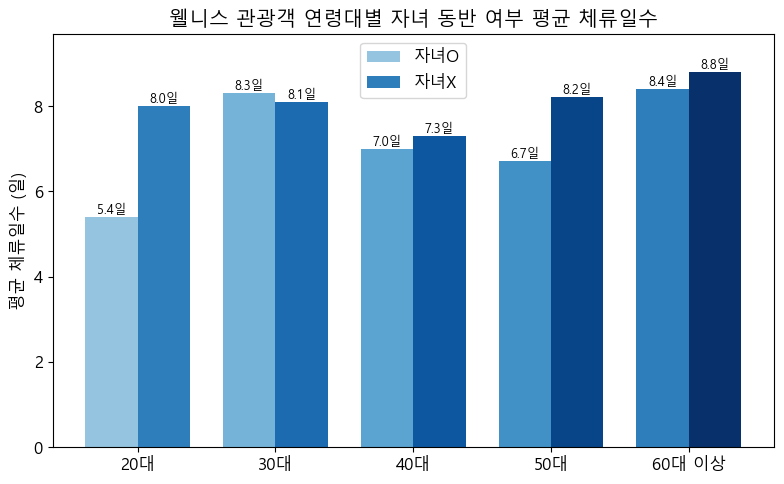

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# x축 설정
labels = pivot.index.tolist()
x = np.arange(len(labels))
width = 0.38  # 막대 너비

# 블루 계열 그라데이션 색상
colors_o = plt.cm.Blues(np.linspace(0.4, 0.7, len(labels)))  # 자녀O
colors_x = plt.cm.Blues(np.linspace(0.7, 1.0, len(labels)))  # 자녀X

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, pivot['자녀O'], width, label='자녀O', color=colors_o)
bars2 = plt.bar(x + width/2, pivot['자녀X'], width, label='자녀X', color=colors_x)

# 막대 위 값 표시
def add_labels(bars):
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h, f'{h:.1f}일', ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)

plt.xticks(x, labels)
plt.ylabel('평균 체류일수 (일)')
plt.title('웰니스 관광객 연령대별 자녀 동반 여부 평균 체류일수')
plt.legend()
plt.ylim(0, np.nanmax(pivot.values) * 1.1)  # 여유 공간
plt.grid(False)
plt.tight_layout()
plt.show()


### 국가별 자녀 여부에 따른 평균 체류일수

In [56]:
# 필터링: 웰니스 관광객 + 선택 국가 + 10대 제외
countries = ['일본', '중국', '미국', '영국', '중동']

df_wellness = df_all[
    (df_all['웰니스참여'] == 1) &
    (df_all['국가명'].isin(countries)) &
    (df_all['연령대_세분화'] != '10대')
]

# 국가별 × 자녀동반 여부별 평균 체류일수
pivot = df_wellness.pivot_table(
    index='국가명',
    columns='자녀동반',
    values='M일HAP',
    aggfunc='mean'
).round(1)

print(pivot)


자녀동반   자녀O   자녀X
국가명             
미국     8.7  11.0
영국    10.2  12.6
일본     3.7   4.1
중국     6.8   7.9
중동    13.5  12.4


In [58]:
# 동행자_세분화 컬럼 중에서 '자녀'와 함께온 관광객은 자녀O, 아닌 그룹은 자녀X 그룹으로 나눔
df_all['자녀동반'] = df_all['동행자_세분화'].apply(lambda x: '자녀O' if x == '자녀' else '자녀X')

# 10대 제외 필터링
df_filtered = df_all[df_all['연령대_단순'] != '10대']

# 웰니스 관광객만 필터링 + 10대 제외
wellness_df = df_all[(df_all['웰니스참여'] == 1)]

# 자녀 동반 여부별 평균 체류일수 계산
means = wellness_df.groupby('자녀동반')['M일HAP'].mean()
print("자녀O 평균 체류일수:", means['자녀O'])
print("자녀X 평균 체류일수:", means['자녀X'])

자녀O 평균 체류일수: 7.15606936416185
자녀X 평균 체류일수: 8.005918307946056


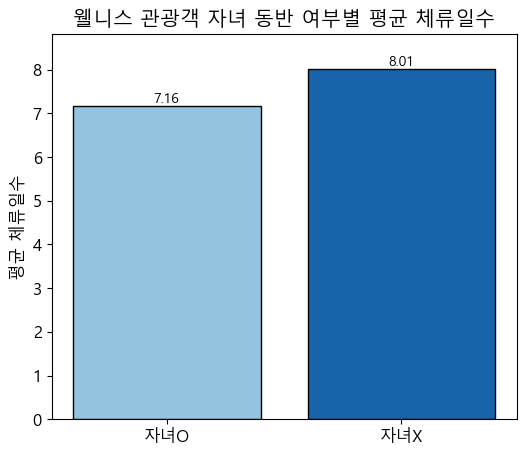

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

labels = means.index.tolist()
values = means.values.tolist()

# 블루 계열 그라데이션 색상 생성
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(values)))

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, values, color=colors, edgecolor='black')

# 막대 위 y값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylabel('평균 체류일수')
plt.title('웰니스 관광객 자녀 동반 여부별 평균 체류일수')
plt.ylim(0, max(values) * 1.1)  # 여유 공간
plt.grid(False)
plt.show()


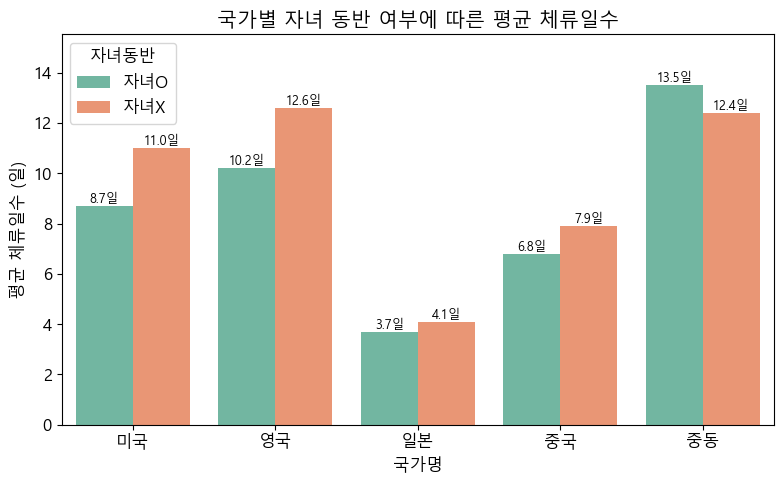

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# pivot 데이터를 long 형식으로 변환
df_plot = pivot.reset_index().melt(id_vars='국가명', var_name='자녀동반', value_name='평균체류일수')

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_plot,
    x='국가명',
    y='평균체류일수',
    hue='자녀동반',
    palette='Set2'
)

# 막대 위 값 표시
# 막대 위 값 표시 (0 또는 NaN은 제외)
for p in ax.patches:
    height = p.get_height()
    if pd.notnull(height) and height != 0:  # NaN이 아니고 0이 아닐 때만 표시
        ax.annotate(f'{height:.1f}일',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=9)

plt.title('국가별 자녀 동반 여부에 따른 평균 체류일수')
plt.ylabel('평균 체류일수 (일)')
plt.xlabel('국가명')
plt.ylim(0, df_plot['평균체류일수'].max() * 1.15)
plt.legend(title='자녀동반')
plt.tight_layout()
plt.show()


#### 왜 자녀를 동반하면 소비가 줄어들까?

1. 1인당 지출이 분산됨
- 숙소·음식·이동 등에서 전체 비용은 증가하나, 개별 체험/사치 지출은 감소

2. 자녀 중심 일정으로 전환됨
- 웰니스 콘텐츠(명상, 뷰티, 스파 등)는 어른 중심 활동
- 자녀가 있으면 소극적 선택, 체험 종류 제한됨 (시간, 활동 측면에서 제약)

3. 왜 30~50대 자녀 미동반자는 핵심 소비자인가?
- 경제활동 주력층 + 체력과 여가 모두 확보된 세대
- 자녀 없이 여행할 경우: 자기만족 중심 소비 가능
- 웰니스 콘텐츠(명상, 스파, 치유 등)에 높은 관심과 지출 여력

4. 결론
- 웰니스 관광의 핵심 소비자는 ‘자녀 없이 여행하는 30~50대’다.

- 관광객 / 웰니스 관광객 구분해서 더 분석해보기

### 웰니스 관광객 연령대와 사용 총액 분석

In [60]:
# 웰니스 관광객만 필터링
wellness_df = df_all[df_all['웰니스참여'] == 1]

In [61]:
wellness_df

,D_NAT,M일HAP,Q7A,Q7a_dk,Q7a2,Q7a3,Q7a4,Q7a5,Q7a6,Q7a7,...,동행자_세분화,국가명,연령대_단순,연령대_세분화,웰니스참여,웰니스만족,log_총액,year,예상_총액,자녀동반
1,1,7,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,혼자,중국,30~50대,30대,1,1,7.390971,2023,1620.280000,자녀X
4,3,8,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,대만,20대,20대,1,1,7.197884,2023,1335.600000,자녀X
7,5,6,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,홍콩,30~50대,30대,1,1,7.490440,2023,1789.840000,자녀X
8,3,6,2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,배우자/파트너,대만,20대,20대,1,1,6.691116,2023,804.220000,자녀X
9,3,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,대만,30~50대,30대,1,1,7.210006,2023,1351.900000,자녀X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17117,1,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,중국,20대,20대,1,1,6.204900,2024,494.169633,자녀X
17118,1,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,중국,30~50대,40대,1,1,6.053570,2024,424.630000,자녀X
17120,1,5,2,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,자녀,중국,30~50대,50대,1,1,7.845392,2024,2552.938220,자녀O
17121,1,5,2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,배우자/파트너,중국,30~50대,50대,1,1,6.426246,2024,616.850000,자녀X


In [62]:
# 웰니스 관광객 연령대 분포
wellness_df['연령대_단순'].value_counts()

연령대_단순
30~50대    6243
20대       3693
60대 이상     643
10대        247
Name: count, dtype: int64

In [63]:
# 웰니스 관광객 연령대 분포
wellness_df['연령대_세분화'].value_counts()

연령대_세분화
20대       3693
30대       2601
50대       1911
40대       1731
60대 이상     643
10대        247
Name: count, dtype: int64

In [64]:
# 전체 연령대 분포
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [65]:
# 연령대별 비율 
ratio_by_age = (wellness_df['연령대_단순']
                .value_counts(normalize=True)
                .sort_index() * 100).round(1)

print(ratio_by_age)

연령대_단순
10대        2.3
20대       34.1
30~50대    57.7
60대 이상     5.9
Name: proportion, dtype: float64


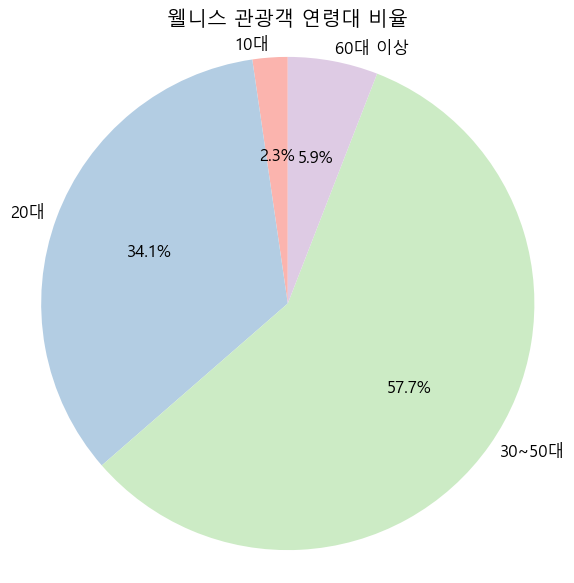

In [66]:
# 연령대 비율 시각화
labels = ratio_by_age.index.tolist()
sizes = ratio_by_age.values.tolist()

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel1.colors,
    labeldistance=1.05  # ← 조각과 라벨의 거리 조절 (기본값은 1.1)
)
plt.title('웰니스 관광객 연령대 비율')
plt.axis('equal')
plt.show()

In [67]:
# 연령대별 비율 
ratio_by_age = (wellness_df['연령대_세분화']
                .value_counts(normalize=True)
                .sort_index() * 100).round(1)

print(ratio_by_age)

연령대_세분화
10대        2.3
20대       34.1
30대       24.0
40대       16.0
50대       17.7
60대 이상     5.9
Name: proportion, dtype: float64


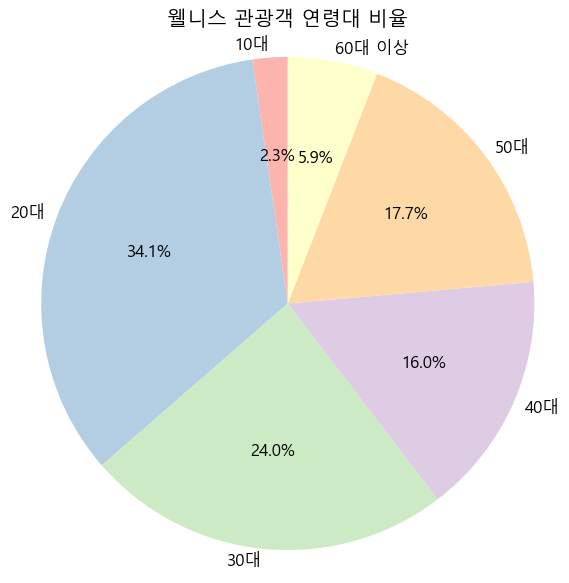

In [68]:
# 연령대 비율 시각화
labels = ratio_by_age.index.tolist()
sizes = ratio_by_age.values.tolist()

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel1.colors,
    labeldistance=1.05  # ← 조각과 라벨의 거리 조절 (기본값은 1.1)
)
plt.title('웰니스 관광객 연령대 비율')
plt.axis('equal')
plt.show()

In [69]:
# 10대 제외
wellness_df = wellness_df[wellness_df['연령대_단순'] != '10대']

In [147]:
# 연령대별 평균 소비액 (자녀미동반)
avg_total = wellness_df.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().round(1)
print(avg_total)

연령대_단순
20대       1280.4
30~50대    1430.0
60대 이상    1302.1
Name: 총액1인TOT항공제외2, dtype: float64


In [71]:
avg_total = wellness_df.groupby('연령대_세분화')['총액1인TOT항공제외2'].mean().round(1)
print(avg_total)

연령대_세분화
20대       1280.4
30대       1450.5
40대       1435.6
50대       1396.9
60대 이상    1302.1
Name: 총액1인TOT항공제외2, dtype: float64


C:\Users\82106\AppData\Local\Temp\ipykernel_16740\1236761808.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='연령대_단순', y='총액1인TOT항공제외2', data=avg_total_df, palette='Blues_d')


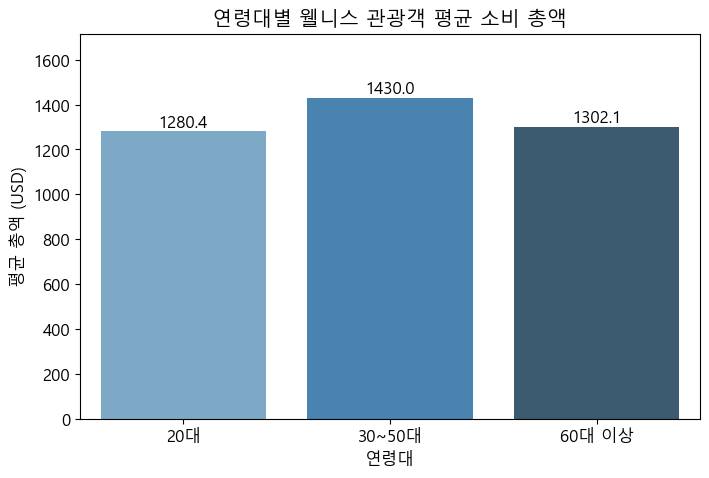

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화용 DataFrame으로 변환
avg_total_df = wellness_df.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().round(1).reset_index()

# 그래프 그리기
plt.figure(figsize=(8, 5))
sns.barplot(x='연령대_단순', y='총액1인TOT항공제외2', data=avg_total_df, palette='Blues_d')
plt.title('연령대별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 총액 (USD)')
plt.ylim(0, avg_total_df['총액1인TOT항공제외2'].max() * 1.2)  # y축 여유롭게

# 막대 위에 값 표시
for i, row in avg_total_df.iterrows():
    plt.text(i, row['총액1인TOT항공제외2'] + 20, f"{row['총액1인TOT항공제외2']}", ha='center')

plt.show()

- 30~50대: 전체 참여자의 59% 차지 + 평균 소비 최고 -> 웰니스 시장의 압도적 핵심 타겟
- 20대: 약 35%의 비율로 비교적 많이 참여 -> 참여율은 높지만 소비는 가장 낮음 -> 저가 체험형 콘텐츠 (가성비)
- 60대 이상: 소수지만 탄탄한 수요층 -> 참여자는 6.1%로 적지만 평균 소비는 1,300달러 수준 -> 건강 치유형 콘텐츠 타겟, 소규모 집중 마케팅
- 웰니스 관광은 30~50대가 양적·질적으로 모두 핵심이며, 20대는 참여 유도층, 60대는 치유형 니치 마켓으로 활용 가능하다.

C:\Users\82106\AppData\Local\Temp\ipykernel_16740\2529786357.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='연령대_세분화', y='총액1인TOT항공제외2', data=avg_total_df, palette='Blues_d')


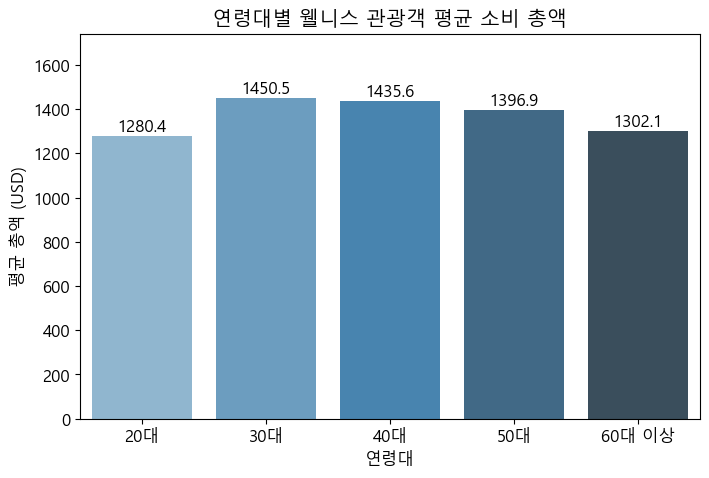

In [73]:
# 시각화용 DataFrame으로 변환
avg_total_df = wellness_df.groupby('연령대_세분화')['총액1인TOT항공제외2'].mean().round(1).reset_index()

# 그래프 그리기
plt.figure(figsize=(8, 5))
sns.barplot(x='연령대_세분화', y='총액1인TOT항공제외2', data=avg_total_df, palette='Blues_d')
plt.title('연령대별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 총액 (USD)')
plt.ylim(0, avg_total_df['총액1인TOT항공제외2'].max() * 1.2)  # y축 여유롭게

# 막대 위에 값 표시
for i, row in avg_total_df.iterrows():
    plt.text(i, row['총액1인TOT항공제외2'] + 20, f"{row['총액1인TOT항공제외2']}", ha='center')

plt.show()

- 30, 40대가 가장 큰 웰니스 관광 소비층 
- 30~50대 전체를 핵심 소비군으로 묶는 전략 가능

In [74]:
# 웰니스 관광객만 필터링
wellness_df = df_all[df_all['웰니스참여'] == 1]

# 10대 제외
wellness_df = wellness_df[wellness_df['연령대_세분화'] != '10대']

# 연령대별 평균 체류일수 계산
means = wellness_df.groupby('연령대_세분화')['M일HAP'].mean().sort_index()
print(means)

연령대_세분화
20대       7.976983
30대       8.112265
40대       7.266898
50대       8.042386
60대 이상    8.788491
Name: M일HAP, dtype: float64


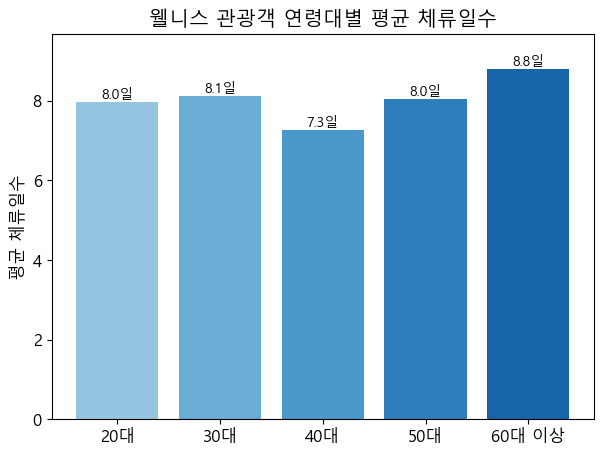

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

labels = means.index.tolist()
values = means.values.tolist()

# 블루 계열 그라데이션 색상 생성
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(values)))  # 밝기 범위 조정 가능

plt.figure(figsize=(7, 5))
bars = plt.bar(labels, values, color=colors)

# 막대 위 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}일', ha='center', va='bottom', fontsize=10)

plt.ylabel('평균 체류일수')
plt.title('웰니스 관광객 연령대별 평균 체류일수')
plt.ylim(0, max(values) * 1.1)
plt.grid(False)
plt.show()


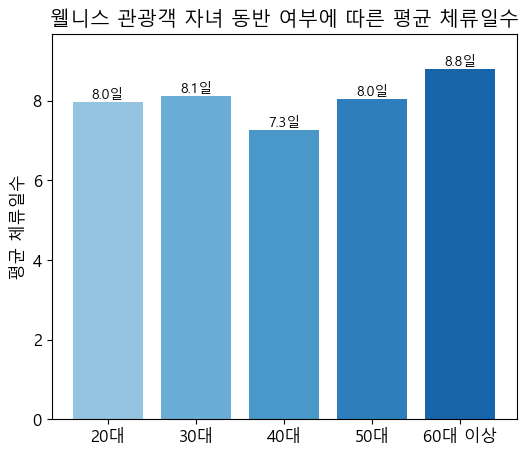

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

labels = means.index.tolist()
values = means.values.tolist()

# 블루 계열 그라데이션 색상 생성
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(values)))  # 0.4~0.8 범위의 블루 톤

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, values, color=colors)

# 막대 위 y값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}일', ha='center', va='bottom', fontsize=10)

plt.ylabel('평균 체류일수')
plt.title('웰니스 관광객 자녀 동반 여부에 따른 평균 체류일수')
plt.ylim(0, max(values) * 1.1)  # 여유 공간
plt.grid(False)
plt.show()


###  웰니스 관광객 × 자녀 동반 여부에 따른 소비 총액 분석

In [77]:
# 웰니스 참여자 중 자녀 동반자 연령대 
wellness_with_child = df_all[(df_all['웰니스참여'] == 1) & (df_all['자녀동반'] == '자녀O')]

In [78]:
wellness_with_child['연령대_단순'].value_counts()

연령대_단순
30~50대    436
60대 이상     71
20대        11
10대         1
Name: count, dtype: int64

In [79]:
wellness_with_child['연령대_세분화'].value_counts()

연령대_세분화
50대       248
40대       118
60대 이상     71
30대        70
20대        11
10대         1
Name: count, dtype: int64

In [80]:
# 10대 제외
wellness_with_child = wellness_with_child[wellness_with_child['연령대_단순'] != '10대']

In [81]:
# 연령대별 비율 (%) 계산
child_ratio = (wellness_with_child['연령대_단순']
               .value_counts(normalize=True)
               .sort_index() * 100).round(1)

print(child_ratio)

연령대_단순
20대        2.1
30~50대    84.2
60대 이상    13.7
Name: proportion, dtype: float64


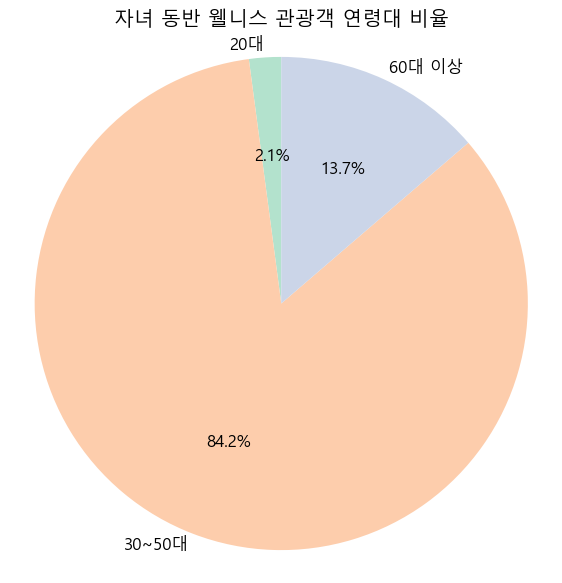

In [82]:
import matplotlib.pyplot as plt

labels = child_ratio.index.tolist()
sizes = child_ratio.values.tolist()

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel2.colors, 
    labeldistance=1.05  # 라벨과 그래프 조각 간 거리 좁힘
)
plt.title('자녀 동반 웰니스 관광객 연령대 비율')
plt.axis('equal')  # 원형 유지
plt.show()

In [83]:
# 10대 제외
wellness_with_child = wellness_with_child[wellness_with_child['연령대_세분화'] != '10대']

In [84]:
# 연령대별 비율 (%) 계산
child_ratio2 = (wellness_with_child['연령대_세분화']
               .value_counts(normalize=True)
               .sort_index() * 100).round(1)

print(child_ratio2)

연령대_세분화
20대        2.1
30대       13.5
40대       22.8
50대       47.9
60대 이상    13.7
Name: proportion, dtype: float64


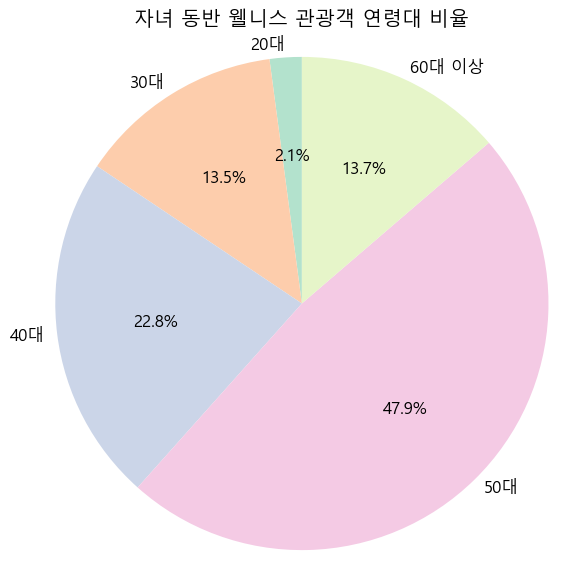

In [85]:
import matplotlib.pyplot as plt

labels = child_ratio2.index.tolist()
sizes = child_ratio2.values.tolist()

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Pastel2.colors, 
    labeldistance=1.05  # 라벨과 그래프 조각 간 거리 좁힘
)
plt.title('자녀 동반 웰니스 관광객 연령대 비율')
plt.axis('equal')  # 원형 유지
plt.show()

In [86]:
# 자녀 동반 여부별 평균 총액
pivot_wellness = wellness_df.pivot_table(
    index='연령대_단순',
    columns='자녀동반',
    values='총액1인TOT항공제외2',
    aggfunc='mean'
).round(1)

print(pivot_wellness)

자녀동반       자녀O     자녀X
연령대_단순                
20대     1635.3  1279.3
30~50대  1345.6  1436.3
60대 이상  1153.7  1320.5


In [87]:
# 자녀 동반 여부별 평균 총액
pivot_wellness = wellness_df.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='총액1인TOT항공제외2',
    aggfunc='mean'
).round(1)

print(pivot_wellness)

자녀동반        자녀O     자녀X
연령대_세분화                
20대      1635.3  1279.3
30대      1160.8  1458.5
40대      1573.8  1425.5
50대      1289.3  1413.0
60대 이상   1153.7  1320.5


In [88]:
# 시각화
# 1. Pivot → Long Format 변환
pivot_wellness_reset = pivot_wellness.reset_index()

pivot_melted = pivot_wellness_reset.melt(
    id_vars='연령대_단순', 
    value_vars=['자녀O', '자녀X'],
    var_name='자녀동반', 
    value_name='총액1인TOT항공제외2'
)

# 2. Grouped Barplot 그리기
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='연령대_단순', 
    y='총액1인TOT항공제외2', 
    hue='자녀동반', 
    data=pivot_melted, 
    palette='Set2'
)
plt.title('연령대별 × 자녀 동반 여부별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 소비 총액 (USD)')
plt.legend(title='자녀 동반 여부')
plt.ylim(0, pivot_melted['총액1인TOT항공제외2'].max() * 1.2)

# 3. 막대 위 숫자 표시
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height != 0.0:  # NaN 및 0.0 모두 방지
        ax.annotate(f'{height:.1f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=9)
plt.show()


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['연령대_단순']"

- 30~50대가 자녀 동반 웰니스의 실질 타겟 
- 가족 중심 콘텐츠, 프리미엄 숙소/리조트, 쇼핑 연계형 웰니스 전략 적합
- 60대 이상은 자녀와 동반 여행할 가능성 존재 (전체의 13.7% 차지 → 니치 타겟 가능)
- 건강/치유형 콘텐츠 + 효도형 여행 마케팅 전략 활용 가능
- 20대는 분석상 제외 가능 -> 자녀 동반은 의미 없는 수준 (2.1%)
- 개별 소비자 중심 마케팅이 적절 (가성비 중심)

- 30~50대: 자녀 없이 여행할 때 소비 높음 -> 자녀를 동반하지 않았을 때 소비가 약 91달러 더 높음
- 이 연령대는 자녀 없이 여유롭게 고가 소비하는 특성이 뚜렷 
- 60대 이상도 자녀 미동반이 더 많이 씀 -> 자녀를 동반하지 않은 경우 약 167달러 더 소비
- 단독/부부 여행자 중심 소비 성향 

1. 자녀 동반 시 소비 감소 경향
- 30~50대, 60대 이상 공통
- 자녀 동반 여행은 소비 분산 및 절제 경향
- 개별 또는 부부 여행자 중심 마케팅이 효과적

2. 웰니스 핵심 소비자 = 자녀 없이 여행하는 중장년층
- 타겟: 30~50대 자녀 미동반층
- 전략: 프리미엄 스파/명상/힐링 콘텐츠, 고급 숙소 연계

In [89]:
# 자녀 동반 여부별 평균 총액 (연령대 세분화)
pivot_wellness2 = wellness_df.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='총액1인TOT항공제외2',
    aggfunc='mean'
).round(1)

print(pivot_wellness2)

자녀동반        자녀O     자녀X
연령대_세분화                
20대      1635.3  1279.3
30대      1160.8  1458.5
40대      1573.8  1425.5
50대      1289.3  1413.0
60대 이상   1153.7  1320.5


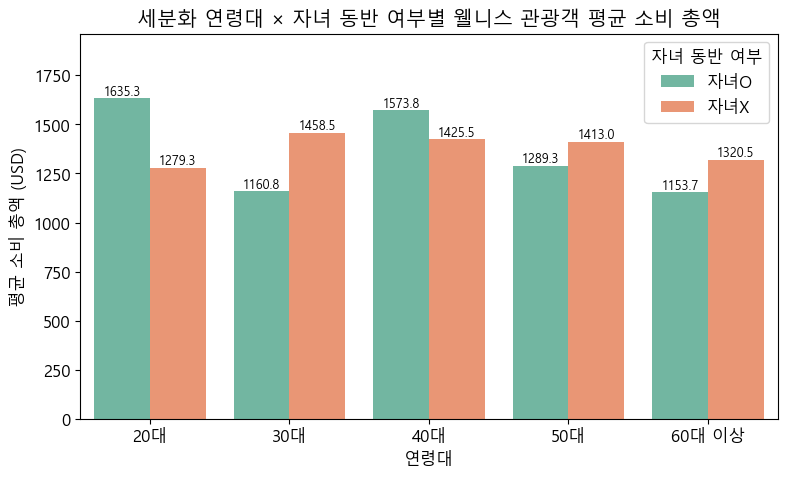

In [90]:
# 시각화 
pivot_reset = pivot_wellness2.reset_index()

pivot_melted = pivot_reset.melt(
    id_vars='연령대_세분화', 
    value_vars=['자녀O', '자녀X'],
    var_name='자녀동반', 
    value_name='총액1인TOT항공제외2'
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    x='연령대_세분화', 
    y='총액1인TOT항공제외2', 
    hue='자녀동반', 
    data=pivot_melted, 
    palette='Set2'
)
plt.title('세분화 연령대 × 자녀 동반 여부별 웰니스 관광객 평균 소비 총액')
plt.xlabel('연령대')
plt.ylabel('평균 소비 총액 (USD)')
plt.legend(title='자녀 동반 여부')
plt.ylim(0, pivot_melted['총액1인TOT항공제외2'].max() * 1.2)

# 막대 위 숫자 표시 (소수점 1자리)
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height != 0.0:
        ax.annotate(f'{height:.1f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=9)

plt.show()


In [91]:
# 자녀 동반 웰니스 관광객만 필터링
wellness_with_child = df_all[(df_all['웰니스참여'] == 1) & (df_all['자녀동반'] == '자녀O')]

# 10대 제외
wellness_with_child = wellness_with_child[wellness_with_child['연령대_세분화'] != '10대']

# 연령대별 평균 소비 총액 계산
mean_by_age = wellness_with_child.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().round(1)

print(mean_by_age)

연령대_단순
20대       1635.3
30~50대    1345.6
60대 이상    1153.7
Name: 총액1인TOT항공제외2, dtype: float64


In [92]:
# 자녀 동반 웰니스 관광객만 필터링 (20대 포함 전체 대상)
wellness_with_child = df_all[(df_all['웰니스참여'] == 1) & (df_all['자녀동반'] == '자녀O')]

# 10대 제외
wellness_with_child = wellness_with_child[wellness_with_child['연령대_세분화'] != '10대']

# 연령대별 중앙값 계산
median_by_age = wellness_with_child.groupby('연령대_단순')['총액1인TOT항공제외2'].median().round(1)
print(median_by_age)

연령대_단순
20대       1294.6
30~50대     967.7
60대 이상     878.5
Name: 총액1인TOT항공제외2, dtype: float64


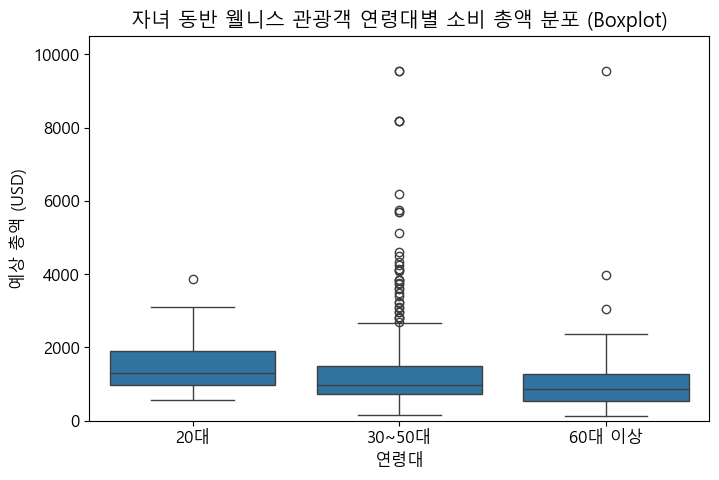

In [93]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='연령대_단순', y='총액1인TOT항공제외2', data=wellness_with_child, order=sorted(wellness_with_child['연령대_단순'].unique()))
plt.title('자녀 동반 웰니스 관광객 연령대별 소비 총액 분포 (Boxplot)')
plt.xlabel('연령대')
plt.ylabel('예상 총액 (USD)')
plt.ylim(0, wellness_with_child['총액1인TOT항공제외2'].max() * 1.1)
plt.show()


최종 해석 및 전략
1. 20대 자녀 동반자는 소비 왜곡 → 고소득 타겟 아님
- 평균 1,634달러 → 실제 중앙값 1,293달러

- 박스플롯 이상치로 인해 평균 과대

-자녀 동반 20대는 타겟 제외, 개별 소비 마케팅만 적합

2. 30~50대 자녀 동반자 → 소비 핵심층
- 평균, 중앙값 모두 상대적으로 높음

- 샘플 수 400명 이상 → 신뢰성 높음

- 가족형 콘텐츠 + 고가 웰니스 상품 타겟 적합

3. 60대 이상은 중간 소비층 → 효도/치유형 콘텐츠 적합
- 평균 1,152달러, 중앙값 877달러

- 중저가 상품 타겟 + 가족 동반 효도 여행 콘텐츠 전략

4. 결론 요약
- 자녀를 동반한 웰니스 관광은 30~50대 중심

## 국적 × 연령대별 소비 총액
- 웰니스 참여자 중 국적별로 연령대에 따른 소비 패턴 차이 비교

In [94]:
wellness_df

,D_NAT,M일HAP,Q7A,Q7a_dk,Q7a2,Q7a3,Q7a4,Q7a5,Q7a6,Q7a7,...,동행자_세분화,국가명,연령대_단순,연령대_세분화,웰니스참여,웰니스만족,log_총액,year,예상_총액,자녀동반
1,1,7,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,혼자,중국,30~50대,30대,1,1,7.390971,2023,1620.280000,자녀X
4,3,8,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,대만,20대,20대,1,1,7.197884,2023,1335.600000,자녀X
7,5,6,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,홍콩,30~50대,30대,1,1,7.490440,2023,1789.840000,자녀X
8,3,6,2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,배우자/파트너,대만,20대,20대,1,1,6.691116,2023,804.220000,자녀X
9,3,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,대만,30~50대,30대,1,1,7.210006,2023,1351.900000,자녀X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17117,1,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,중국,20대,20대,1,1,6.204900,2024,494.169633,자녀X
17118,1,5,2,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,친구,중국,30~50대,40대,1,1,6.053570,2024,424.630000,자녀X
17120,1,5,2,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,자녀,중국,30~50대,50대,1,1,7.845392,2024,2552.938220,자녀O
17121,1,5,2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,배우자/파트너,중국,30~50대,50대,1,1,6.426246,2024,616.850000,자녀X


In [95]:
# Groupby로 국적-연령대별 소비 평균/중앙값
grouped = wellness_df.groupby(['국가명', '연령대_단순'])['총액1인TOT항공제외2']
mean_df = grouped.mean().reset_index(name='평균_총액')
median_df = grouped.median().reset_index(name='중앙값_총액')

In [96]:
mean_df

,국가명,연령대_단순,평균_총액
0,대만,20대,1098.579912
1,대만,30~50대,1232.333214
2,대만,60대 이상,1313.516369
3,독일,20대,1592.791309
4,독일,30~50대,1717.653122
5,독일,60대 이상,1638.454431
6,미국,20대,1559.250756
7,미국,30~50대,1607.296211
8,미국,60대 이상,1667.967690
9,베트남,20대,1106.953201


In [97]:
median_df

,국가명,연령대_단순,중앙값_총액
0,대만,20대,872.100000
1,대만,30~50대,985.600000
2,대만,60대 이상,943.900000
3,독일,20대,1353.674250
4,독일,30~50대,1451.504681
5,독일,60대 이상,1148.237143
6,미국,20대,1280.000000
7,미국,30~50대,1144.871795
8,미국,60대 이상,1143.856655
9,베트남,20대,923.030000


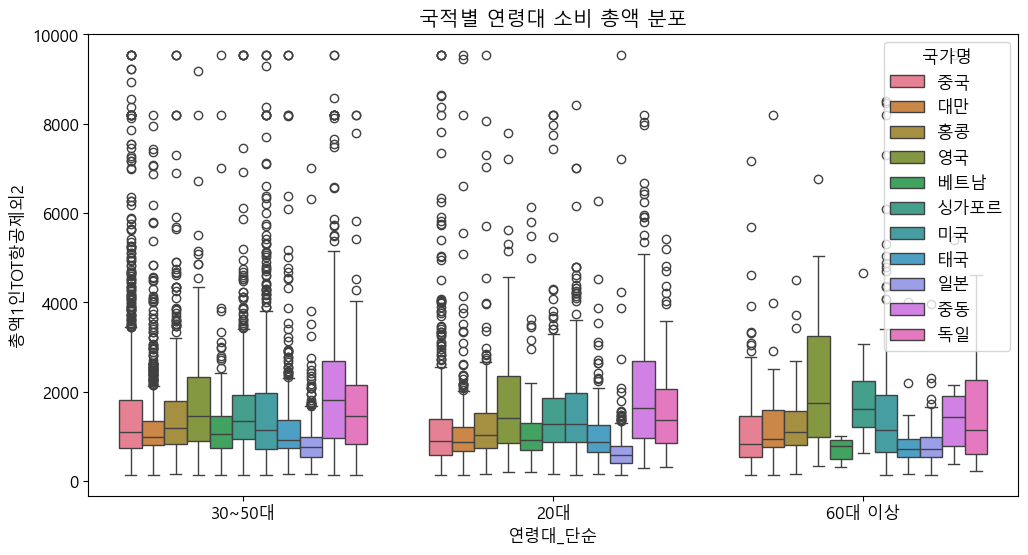

In [98]:
# 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(data=wellness_df, x='연령대_단순', y='총액1인TOT항공제외2', hue='국가명')
plt.title('국적별 연령대 소비 총액 분포')
plt.show()

In [99]:
# 국적 × 연령대별 평균 소비액
mean_df = wellness_df.groupby(['국가명', '연령대_단순'])['총액1인TOT항공제외2'].mean().reset_index()

# 평균 소비액 높은 순 정렬
mean_sorted = mean_df.sort_values(by='총액1인TOT항공제외2', ascending=False)

# 상위 10개 확인
print(mean_sorted)

     국가명  연령대_단순  총액1인TOT항공제외2
25    중동  30~50대   2297.273847
17    영국  60대 이상   2248.585589
26    중동  60대 이상   2196.178649
24    중동     20대   2078.892857
16    영국  30~50대   1778.510867
14  싱가포르  60대 이상   1778.145322
15    영국     20대   1759.019632
4     독일  30~50대   1717.653122
8     미국  60대 이상   1667.967690
5     독일  60대 이상   1638.454431
13  싱가포르  30~50대   1634.964204
22    중국  30~50대   1626.295086
7     미국  30~50대   1607.296211
3     독일     20대   1592.791309
6     미국     20대   1559.250756
12  싱가포르     20대   1553.196983
31    홍콩  30~50대   1542.835912
2     대만  60대 이상   1313.516369
30    홍콩     20대   1307.701162
32    홍콩  60대 이상   1304.958239
21    중국     20대   1298.864571
23    중국  60대 이상   1239.842441
1     대만  30~50대   1232.333214
28    태국  30~50대   1214.598001
10   베트남  30~50대   1162.226451
9    베트남     20대   1106.953201
0     대만     20대   1098.579912
27    태국     20대   1049.892101
29    태국  60대 이상    891.722545
19    일본  30~50대    832.563149
20    일본  60대 이상    794.320546
11   베트남

['중동', '영국', '독일', '싱가포르', '미국', '중국', '홍콩', '대만', '태국', '베트남', '일본']


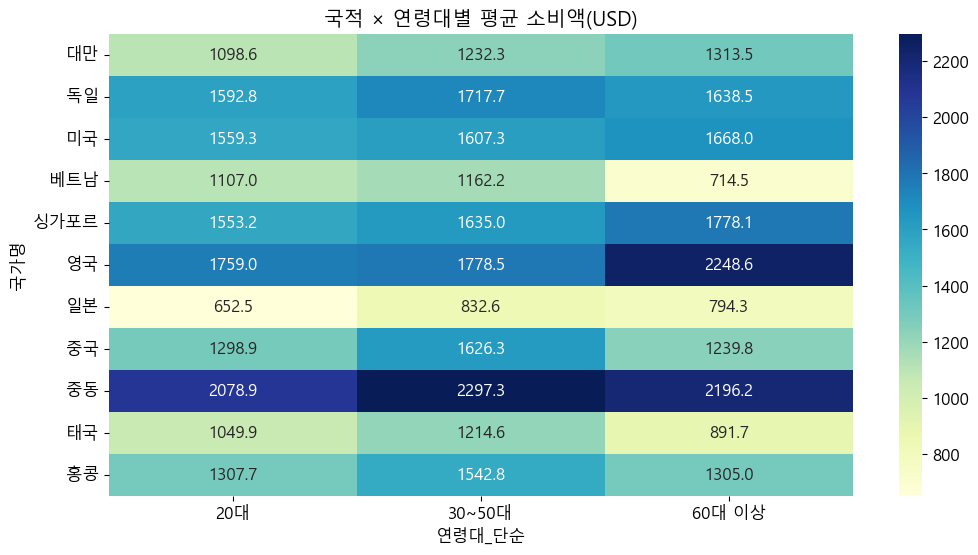

In [100]:
# 국적별 평균 소비액
pivot = wellness_df.groupby('국가명')['총액1인TOT항공제외2'].mean().sort_values(ascending=False)

# 상위 5개 국적 확인
top_countries = pivot.index.tolist()
print(top_countries)

# 히트맵: 국적 × 연령대별 평균 소비액
pivot_table = wellness_df.pivot_table(index='국가명', columns='연령대_단순', values='총액1인TOT항공제외2', aggfunc='mean')

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('국적 × 연령대별 평균 소비액(USD)')
plt.show()

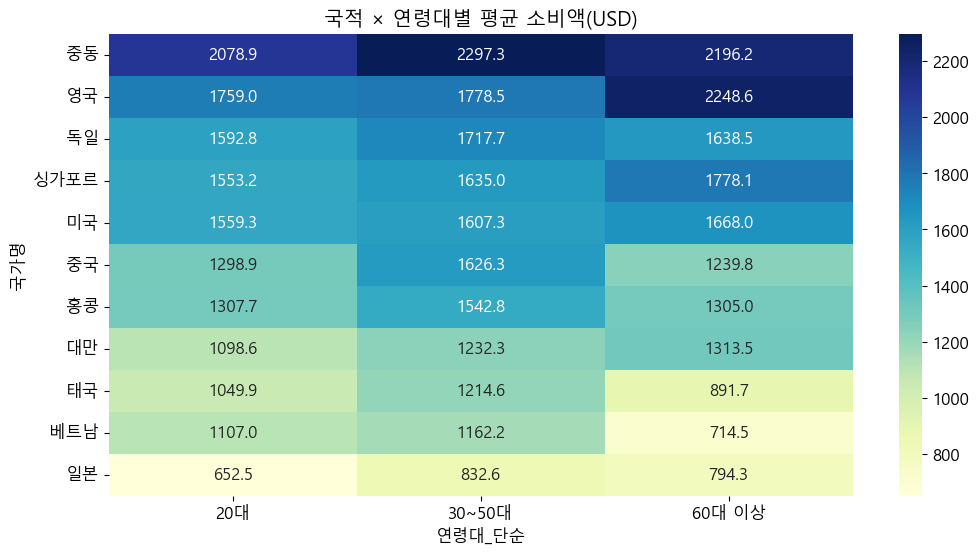

In [101]:
# 국적별 평균 소비액 (내림차순)
pivot = wellness_df.groupby('국가명')['총액1인TOT항공제외2'].mean().sort_values(ascending=False)

# 정렬된 국가명 리스트
top_countries = pivot.index.tolist()

# pivot_table 생성 후 국가명 순서 지정 (상위권 → 하위권)
pivot_table = wellness_df.pivot_table(
    index='국가명',
    columns='연령대_단순',
    values='총액1인TOT항공제외2',
    aggfunc='mean'
).loc[top_countries]

# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('국적 × 연령대별 평균 소비액(USD)')
plt.show()


In [102]:
# 국적별 웰니스 관광 평균 소비액
country_mean = wellness_df.groupby('국가명')['총액1인TOT항공제외2'].mean().sort_values(ascending=False).reset_index()

print("[국적별 웰니스 참여자 평균 소비액 (USD)]")
print(country_mean.round(1))

[국적별 웰니스 참여자 평균 소비액 (USD)]
     국가명  총액1인TOT항공제외2
0     중동        2200.0
1     영국        1795.1
2     독일        1647.2
3   싱가포르        1611.3
4     미국        1598.1
5     중국        1499.1
6     홍콩        1449.0
7     대만        1197.1
8     태국        1158.2
9    베트남        1138.8
10    일본         754.7


In [103]:
# 자녀 동반 여부별 평균 소비액 계산 (wellness_df는 이미 웰니스 참여자만 포함)
child_mean = wellness_df.groupby('자녀동반')['총액1인TOT항공제외2'].mean().reset_index()

# # 보기 좋게 0 → '자녀X', 1 → '자녀O'로 변환
# child_mean['자녀동반'] = child_mean['자녀동반'].map({0: '자녀X', 1: '자녀O'})

print("[웰니스 참여자 자녀 동반 여부별 평균 소비액 (USD)]")
print(child_mean.round(1))

[웰니스 참여자 자녀 동반 여부별 평균 소비액 (USD)]
  자녀동반  총액1인TOT항공제외2
0  자녀O        1325.5
1  자녀X        1372.3


#### 일본

In [104]:
japan_df = wellness_df[wellness_df['국가명'] == '일본']

In [105]:
# 동반자 유형별 연령대 분포 + 비율
age_counts = japan_df['연령대_단순'].value_counts()
age_counts


연령대_단순
30~50대    712
20대       608
60대 이상    168
Name: count, dtype: int64

In [106]:
age_ratio = age_counts / age_counts.sum() * 100
age_ratio

연령대_단순
30~50대    47.849462
20대       40.860215
60대 이상    11.290323
Name: count, dtype: float64

- 30-50대 중심, 60대 이상은 소수

In [107]:
# 자녀 동반 여부 비율
child_counts = japan_df['자녀동반'].value_counts()
child_ratio = child_counts / child_counts.sum() * 100

print("[자녀 동반 여부 분포]")
print(child_counts)
print("[비율 %]")
print(child_ratio.round(2))

[자녀 동반 여부 분포]
자녀동반
자녀X    1443
자녀O      45
Name: count, dtype: int64
[비율 %]
자녀동반
자녀X    96.98
자녀O     3.02
Name: count, dtype: float64


- 대부분 자녀없이 방한하는 관광객이 많음

In [108]:
# 자녀 동반자 연령대 
jp_with_child = japan_df[(japan_df['웰니스참여'] == 1) & (japan_df['자녀동반'] == '자녀O')]
jp_with_child['연령대_단순'].value_counts()

연령대_단순
30~50대    34
60대 이상    10
20대        1
Name: count, dtype: int64

In [109]:
# 연령대별 평균 소비액 계산
japan_age_mean = japan_df.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().reset_index()

print("[일본 연령대별 평균 소비액 (USD)]")
print(japan_age_mean.round(1))

[일본 연령대별 평균 소비액 (USD)]
   연령대_단순  총액1인TOT항공제외2
0     20대         652.5
1  30~50대         832.6
2  60대 이상         794.3


In [110]:
# 자녀 동반 여부별 평균 소비액
child_mean = japan_df.groupby('자녀동반')['총액1인TOT항공제외2'].mean()
print("[자녀 동반 여부별 평균 소비액]")
print(child_mean.round(1))

[자녀 동반 여부별 평균 소비액]
자녀동반
자녀O    708.9
자녀X    756.1
Name: 총액1인TOT항공제외2, dtype: float64


- 자녀 동반 시 소비액 감소 (약 $47 차이), 그러나 차이는 크지 않음.

#### 중국

In [111]:
china_df = wellness_df[wellness_df['국가명'] == '중국']

In [112]:
# 동반자 유형별 연령대 분포 + 비율
age_counts = china_df['연령대_단순'].value_counts()
age_counts

연령대_단순
30~50대    1074
20대        566
60대 이상      90
Name: count, dtype: int64

In [113]:
age_ratio = age_counts / age_counts.sum() * 100
age_ratio

연령대_단순
30~50대    62.080925
20대       32.716763
60대 이상     5.202312
Name: count, dtype: float64

- 30-50대가 가장 많이 방문, 20대의 두배
- 60대 이상은 매우 소수

In [114]:
# 자녀 동반 여부 비율
child_counts = china_df['자녀동반'].value_counts()
child_ratio = child_counts / child_counts.sum() * 100

print("[자녀 동반 여부 분포]")
print(child_counts)
print("[비율 %]")
print(child_ratio.round(2))

[자녀 동반 여부 분포]
자녀동반
자녀X    1590
자녀O     140
Name: count, dtype: int64
[비율 %]
자녀동반
자녀X    91.91
자녀O     8.09
Name: count, dtype: float64


- 대부분 자녀 없이 방문

In [115]:
# 자녀 동반자 연령대 
ca_with_child = china_df[(china_df['웰니스참여'] == 1) & (china_df['자녀동반'] == '자녀O')]
ca_with_child['연령대_단순'].value_counts()

연령대_단순
30~50대    130
60대 이상      9
20대         1
Name: count, dtype: int64

- 자녀 동반자 거의 모두 30~50대 부모층

In [116]:
# 연령대별 평균 소비액 계산
china_age_mean = china_df.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().reset_index()

print("[중국 연령대별 평균 소비액 (USD)]")
print(china_age_mean.round(1))

[중국 연령대별 평균 소비액 (USD)]
   연령대_단순  총액1인TOT항공제외2
0     20대        1298.9
1  30~50대        1626.3
2  60대 이상        1239.8


- 30~50대가 고소비층
- 20대, 60대는 비슷한 수준

In [117]:
# 자녀 동반 여부별 평균 소비액
child_mean = china_df.groupby('자녀동반')['총액1인TOT항공제외2'].mean()
print("[자녀 동반 여부별 평균 소비액]")
print(child_mean.round(1))

[자녀 동반 여부별 평균 소비액]
자녀동반
자녀O    1311.1
자녀X    1515.6
Name: 총액1인TOT항공제외2, dtype: float64


- 자녀 없이 여행했을 때 소비액 약 $204 증가

#### 미국

In [118]:
usa_df = wellness_df[wellness_df['국가명'] == '미국']

In [119]:
# 동반자 유형별 연령대 분포 + 비율
age_counts = usa_df['연령대_단순'].value_counts()
age_counts

연령대_단순
30~50대    745
20대       415
60대 이상    132
Name: count, dtype: int64

In [120]:
age_ratio = age_counts / age_counts.sum() * 100
age_ratio

연령대_단순
30~50대    57.662539
20대       32.120743
60대 이상    10.216718
Name: count, dtype: float64

In [121]:
# 자녀 동반 여부 비율
child_counts = usa_df['자녀동반'].value_counts()
child_ratio = child_counts / child_counts.sum() * 100

print("[자녀 동반 여부 분포]")
print(child_counts)
print("[비율 %]")
print(child_ratio.round(2))

[자녀 동반 여부 분포]
자녀동반
자녀X    1234
자녀O      58
Name: count, dtype: int64
[비율 %]
자녀동반
자녀X    95.51
자녀O     4.49
Name: count, dtype: float64


- 자녀 동반률은 일본(3.02)보다 높고, 중국(8.09) 보다 낮음

In [122]:
# 자녀 동반자 연령대 
us_with_child = usa_df[(usa_df['웰니스참여'] == 1) & (usa_df['자녀동반'] == '자녀O')]
us_with_child['연령대_단순'].value_counts()

연령대_단순
30~50대    48
60대 이상     8
20대        2
Name: count, dtype: int64

In [123]:
# 연령대별 평균 소비액 계산
usa_age_mean = usa_df.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().reset_index()

print("[미국 연령대별 평균 소비액 (USD)]")
print(usa_age_mean.round(1))

[미국 연령대별 평균 소비액 (USD)]
   연령대_단순  총액1인TOT항공제외2
0     20대        1559.3
1  30~50대        1607.3
2  60대 이상        1668.0


In [124]:
# 자녀 동반 여부별 평균 소비액
child_mean = usa_df.groupby('자녀동반')['총액1인TOT항공제외2'].mean()
print("[자녀 동반 여부별 평균 소비액]")
print(child_mean.round(1))

[자녀 동반 여부별 평균 소비액]
자녀동반
자녀O    1715.6
자녀X    1592.5
Name: 총액1인TOT항공제외2, dtype: float64


- 세대 전반 소비력 강함 -> 고소득층 다수 추정
- 자녀 동반 시 소비액 증가 경향이 명확함 (약 $123 차이)

#### 영국

In [125]:
uk_df = wellness_df[wellness_df['국가명'] == '영국']

In [126]:
# 동반자 유형별 연령대 분포 + 비율
age_counts = uk_df['연령대_단순'].value_counts()
age_counts

연령대_단순
30~50대    220
20대       201
60대 이상     24
Name: count, dtype: int64

In [127]:
age_ratio = age_counts / age_counts.sum() * 100
age_ratio

연령대_단순
30~50대    49.438202
20대       45.168539
60대 이상     5.393258
Name: count, dtype: float64

- 30-50대, 20대 웰니스 관광 비율이 비슷함
- 60대 이상은 극소수

In [128]:
# 자녀 동반 여부 비율
child_counts = uk_df['자녀동반'].value_counts()
child_ratio = child_counts / child_counts.sum() * 100

print("[자녀 동반 여부 분포]")
print(child_counts)
print("[비율 %]")
print(child_ratio.round(2))

[자녀 동반 여부 분포]
자녀동반
자녀X    440
자녀O      5
Name: count, dtype: int64
[비율 %]
자녀동반
자녀X    98.88
자녀O     1.12
Name: count, dtype: float64


- 자녀없이 방문하는 경우가 압도적으로 많음
- 거의 모든 관광객이 자녀 없이 방문

In [129]:
# 자녀 동반자 연령대 
uk_with_child = uk_df[(uk_df['웰니스참여'] == 1) & (uk_df['자녀동반'] == '자녀O')]
uk_with_child['연령대_단순'].value_counts()

연령대_단순
30~50대    5
Name: count, dtype: int64

- 자녀 동반자는 전원 30~50대

In [130]:
# 연령대별 평균 소비액 계산
uk_age_mean = uk_df.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().reset_index()

print("[영국 연령대별 평균 소비액 (USD)]")
print(uk_age_mean.round(1))

[영국 연령대별 평균 소비액 (USD)]
   연령대_단순  총액1인TOT항공제외2
0     20대        1759.0
1  30~50대        1778.5
2  60대 이상        2248.6


- 60대 이상 압도적 고소비층

In [131]:
# 자녀 동반 여부별 평균 소비액
child_mean = uk_df.groupby('자녀동반')['총액1인TOT항공제외2'].mean()
print("[자녀 동반 여부별 평균 소비액]")
print(child_mean.round(1))

[자녀 동반 여부별 평균 소비액]
자녀동반
자녀O    2485.2
자녀X    1787.2
Name: 총액1인TOT항공제외2, dtype: float64


- 자녀 동반 시 소비액 약 $698 증가
- 다만 동반자 수가 적어 추세 참고용으로 활용 가능

#### 중동

In [132]:
middle_east_df = wellness_df[wellness_df['국가명'] == '중동']

In [133]:
# 동반자 유형별 연령대 분포 + 비율
age_counts = middle_east_df['연령대_단순'].value_counts()
age_counts

연령대_단순
30~50대    246
20대       197
60대 이상     13
Name: count, dtype: int64

In [134]:
age_ratio = age_counts / age_counts.sum() * 100
age_ratio

연령대_단순
30~50대    53.947368
20대       43.201754
60대 이상     2.850877
Name: count, dtype: float64

- 젊은층(20대, 30-50대)이 주로 방문함
- 60대 이상은 극소수

In [135]:
# 자녀 동반 여부 비율
child_counts = middle_east_df['자녀동반'].value_counts()
child_ratio = child_counts / child_counts.sum() * 100

print("[자녀 동반 여부 분포]")
print(child_counts)
print("[비율 %]")
print(child_ratio.round(2))

[자녀 동반 여부 분포]
자녀동반
자녀X    434
자녀O     22
Name: count, dtype: int64
[비율 %]
자녀동반
자녀X    95.18
자녀O     4.82
Name: count, dtype: float64


- 대부분 자녀 없이 방문

In [136]:
# 자녀 동반자 연령대 
me_with_child = middle_east_df[(middle_east_df['웰니스참여'] == 1) & (middle_east_df['자녀동반'] == '자녀O')]
me_with_child['연령대_단순'].value_counts()

연령대_단순
30~50대    20
60대 이상     2
Name: count, dtype: int64

- 자녀 동반자는 대부분 30~50대, 60대 이상은 소수

In [137]:
# 연령대별 평균 소비액 계산
me_age_mean = middle_east_df.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().reset_index()

print("[중동 연령대별 평균 소비액 (USD)]")
print(japan_age_mean.round(1))

[중동 연령대별 평균 소비액 (USD)]
   연령대_단순  총액1인TOT항공제외2
0     20대         652.5
1  30~50대         832.6
2  60대 이상         794.3


In [138]:
# 자녀 동반 여부별 평균 소비액
child_mean = middle_east_df.groupby('자녀동반')['총액1인TOT항공제외2'].mean()
print("[자녀 동반 여부별 평균 소비액]")
print(child_mean.round(1))

[자녀 동반 여부별 평균 소비액]
자녀동반
자녀O    2075.5
자녀X    2206.4
Name: 총액1인TOT항공제외2, dtype: float64


- 자녀 미동반 소비액 더 높음 (차이 약 $131).
- 중동은 전반적으로 고소비 성향을 보이며, 자녀 동반 여부 영향이 적음

#### 국가별 웰니스 전략 요약표
| 국가 | 타깃 연령층     | 자녀 동반율 | 전략 방향 요약                      |
| -- | ---------- | ------ | ----------------------------- |
| 일본 | 30\~50대 중심 | 3%     | 1인/성인 중심 체류형 콘텐츠, 소액 체험 강화    |
| 중국 | 30\~50대 중심 | 8%     | 가족형 프리미엄 콘텐츠, 쇼핑/숙박 연계 확대     |
| 미국 | 전 연령 고소비층  | 4.5%   | 실버층 포함 전 연령 대상 고급 콘텐츠 다양화     |
| 영국 | 젊은층 + 실버층  | 1%     | 고소비층 대상 럭셔리/힐링형 웰니스, 커플형 적합   |
| 중동 | 젊은층 중심     | 4.8%   | VIP 쇼핑/뷰티 중심, 1인/성인 대상 고급 콘텐츠 |

In [139]:
# 대상 국가 리스트
target_countries = ['일본', '미국', '영국', '중동', '중국']

# 결과 저장용 딕셔너리
result = {}

for country in target_countries:
    sub_df = wellness_df[wellness_df['국가명'] == country]
    counts = sub_df['자녀동반'].value_counts()
    ratio = counts / counts.sum() * 100  # 비율 계산 (%)
    
    # 저장
    result[country] = {
        '자녀X(%)': round(ratio.get(0, 0), 2),
        '자녀O(%)': round(ratio.get(1, 0), 2)
    }

C:\Users\82106\AppData\Local\Temp\ipykernel_16740\1226902835.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  '자녀X(%)': round(ratio.get(0, 0), 2),
C:\Users\82106\AppData\Local\Temp\ipykernel_16740\1226902835.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  '자녀O(%)': round(ratio.get(1, 0), 2)
C:\Users\82106\AppData\Local\Temp\ipykernel_16740\1226902835.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  '자녀X(%)': round(ratio

In [140]:
# 결과 보기 (DataFrame으로 변환)
import pandas as pd
child_ratio_df = pd.DataFrame(result).T  # 전치하여 보기 좋게
print(child_ratio_df)

    자녀X(%)  자녀O(%)
일본   96.98    3.02
미국   95.51    4.49
영국   98.88    1.12
중동   95.18    4.82
중국   91.91    8.09
